In [1]:
import cv2
import copy
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.models.detection import MaskRCNN, backbone_utils

In [2]:
# load bubble breakup video
video_path = "./data/w6peg5r7qc140.mp4"
cap = cv2.VideoCapture(video_path)
frames = []
while cap.isOpened():
    _, frame = cap.read()
    if frame is None: break
    frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
cap.release()

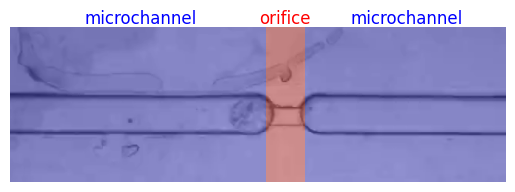

In [3]:
# define region recognition function
def recognize_region(img, edge_thres=30, height_thres=35, min_width=20, border=10):
    # propose horizontal lines
    img_gauss = copy.deepcopy(img)
    img_gauss = cv2.GaussianBlur(img_gauss, (5, 5), 0)
    img_edge = np.stack([
        cv2.Sobel(img_gauss, -1, 0, 1).max(axis=-1),
        cv2.Sobel(img_gauss[::-1], -1, 0, 1).max(axis=-1)[::-1],
    ]).max(axis=0)
    img_edge = ((img_edge > edge_thres) * 255).astype(np.uint8)
    lines = cv2.HoughLinesP(img_edge, 1, np.pi / 180, 80, 
                            minLineLength=30, maxLineGap=10)[:, 0, :]
    lines = [line for line in lines if abs(line[3] - line[1]) < 6]

    h, w = img.shape[0], img.shape[1]
    uppers = np.ones((w, )) * 0
    lowers = np.ones((w, )) * (h - 1)
    for x1, y1, x2, y2 in lines:
        y = (y1 + y2) / 2
        uppers[x1:x2] = np.maximum(uppers[x1:x2], y)
        lowers[x1:x2] = np.minimum(lowers[x1:x2], y)
    heights = uppers - lowers
    indicators = (heights > height_thres).astype(int)
    indicators[:border] = indicators[border]
    indicators[-border:] = indicators[-border-1]
    shifts = np.where(indicators[1:] - indicators[:-1] != 0)[0]
    if len(shifts) == 0: return None
    labels = indicators[shifts].tolist()
    labels.append(indicators[shifts[-1] + 1].item())
    shifts = [0] + [int(p//10*10 + 10*indicators[p+1]) for p in shifts] + [w-1]
    raw_regions = list(zip(shifts[:-1], shifts[1:]))
    regions = []
    for (r, l) in zip(raw_regions, labels):
        if len(regions) == 0:
            regions.append([list(r), l])
        else:
            if l == regions[-1][1] or r[1] - r[0] < min_width:
                regions[-1][0][1] = r[1]
            else:
                regions.append([list(r), l])
    return regions

img = frames[0]
regions = recognize_region(img)
plt.imshow(img)
for r in regions:
    if r[1] == 0:
        rect = plt.Rectangle((r[0][0], 0), r[0][1] - r[0][0], img.shape[0], facecolor='red', alpha=.25)
        plt.gca().add_patch(rect)
        plt.text((r[0][1] + r[0][0]) / 2 - 34, -5, 'orifice', color='red', fontsize=12)
    if r[1] == 1:
        rect = plt.Rectangle((r[0][0], 0), r[0][1] - r[0][0], img.shape[0], facecolor='blue', alpha=.25)
        plt.gca().add_patch(rect)
        plt.text((r[0][1] + r[0][0]) / 2 - 70, -5, 'microchannel', color='blue', fontsize=12)
plt.axis('off')
plt.show()

In [4]:
# load mask-rcnn model
backbone = backbone_utils.resnet_fpn_backbone(
    backbone_name="resnet50", weights=None)
model = MaskRCNN(backbone, 2, box_nms_thresh=0.05, box_detections_per_img=200)
state_dict = torch.load('./ckpt/maskrcnn_resnet50.ckpt')
model.load_state_dict(state_dict)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.eval()
model = model.to(device)

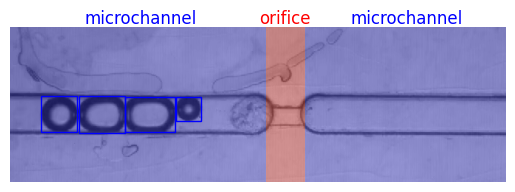

In [5]:
# define video inference function
def infer_video(model, device, frames, interval=4):
    video_res = []
    for frame in frames[::interval]:
        frame = frame.astype(np.uint8)
        frame  = torch.from_numpy(frame).float().permute(2, 0, 1).to(device) / 255
        frame_res = model(frame.unsqueeze(0))[0]
        frame_res = {
            "labels": frame_res["labels"].detach().cpu().numpy(),
            "scores": frame_res["scores"].detach().cpu().numpy(),
            "boxes": frame_res["boxes"].detach().cpu().numpy(),
        }
        video_res.append(frame_res)
    return video_res

video_res = infer_video(model, device, frames)

regions = recognize_region(frames[0])
idx = 15
img = frames[idx * 4]
plt.imshow(img)
for r in regions:
    if r[1] == 0:
        rect = plt.Rectangle((r[0][0], 0), r[0][1] - r[0][0], img.shape[0], facecolor='red', alpha=.25)
        plt.gca().add_patch(rect)
        plt.text((r[0][1] + r[0][0]) / 2 - 34, -5, 'orifice', color='red', fontsize=12)
    if r[1] == 1:
        rect = plt.Rectangle((r[0][0], 0), r[0][1] - r[0][0], img.shape[0], facecolor='blue', alpha=.25)
        plt.gca().add_patch(rect)
        plt.text((r[0][1] + r[0][0]) / 2 - 70, -5, 'microchannel', color='blue', fontsize=12)
for box in zip(video_res[idx]["boxes"], video_res[idx]["labels"]):
    x1, y1, x2, y2 = box[0]
    if box[1] == 1:
        rect = plt.Rectangle((x1-1, y1-1), x2 - x1, y2 - y1, edgecolor='blue', facecolor='none')
        plt.gca().add_patch(rect)
plt.axis('off')
plt.show()

[]

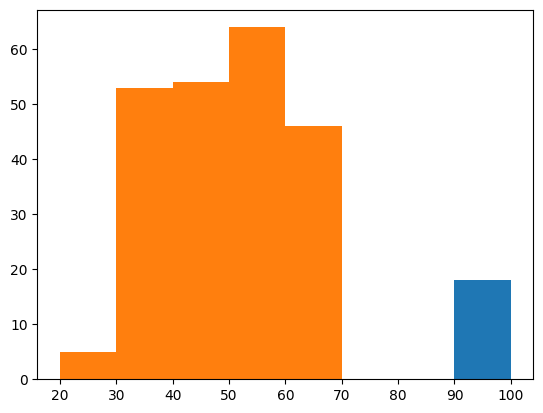

In [6]:
# collect video inference results
def bbox2volume(bbox, channel_width, channel_height):
    width = bbox[2] - bbox[0]
    height = bbox[3] - bbox[1]
    if width > channel_width:
        return channel_width ** 2 * (width - channel_width) + 1/6 * np.pi * channel_width ** 3
    elif width > channel_height:
        return 1/6 * np.pi * channel_height * width * height
    else:
        return 1/6 * np.pi * width ** 3

def collect_video_results(video_res, prev_region, post_region, score_thres=0.9, channel_width=53, channel_height=53):
    prev_ds = []
    post_ds = []
    for j, frame_res in enumerate(video_res):
        for i in range(len(frame_res['labels'])):
            if frame_res['scores'][i] < score_thres: continue
            bbox = frame_res['boxes'][i]
            if bbox[2] - bbox[0] < 9: continue
            if bbox[0] < 10 or bbox[2] > 640 - 10: continue
            volume = bbox2volume(bbox, channel_width, channel_height)
            if bbox[0] > prev_region[0] and bbox[2] < prev_region[1]:
                prev_ds.append((6 * volume / np.pi) ** (1/3))
            if bbox[0] > post_region[0] and bbox[2] < post_region[1]:
                post_ds.append((6 * volume / np.pi) ** (1/3))
    return {
        "prev": prev_ds,
        "post": post_ds,
    }

res = collect_video_results(video_res, prev_region=regions[2][0], post_region=regions[0][0])
bins = np.linspace(20, 100, 9)
plt.hist(res["prev"], bins=bins)
plt.hist(res["post"], bins=bins)
plt.plot()